# Train a Machine Learning Model
Determine the optimal machine learning algorithm and train it.

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(f"{os.getcwd()}/../")
from glob import glob
from copy import deepcopy
from glob import glob
from matminer.featurizers.function import FunctionFeaturizer
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge, LinearRegression, Lasso, LassoLars
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from stopping_power_ml.io import load_qbox_data
import pandas as pd
import numpy as np
import pickle as pkl


/Users/mrl-mrsec/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings; warnings.simplefilter('ignore')

## Load in the Dataset
This was created by a different notebook

In [3]:
data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))
print('Data set size:', len(data))

Data set size: 9800


Remove the initial transient

In [4]:
data.query('initial == False', inplace=True)
print('Training set size:', len(data))

Training set size: 9379


Determine which columns are inputs

In [6]:
featurizers = pkl.load(open(os.path.join('..', 'featurizers.pkl'), 'rb'))

In [7]:
X_cols = featurizers.feature_labels()
print(X_cols)

['charge density at t=-4.00', 'charge density at t=-3.00', 'charge density at t=-2.00', 'charge density at t=-1.00', 'charge density at t=-0.50', 'charge density at t=0.00', 'charge density at t=0.50', 'charge density at t=1.00', 'charge density at t=2.00', 'AGNI projected eta=8.00e-01', 'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00', 'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00', 'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01', 'AGNI projected eta=1.60e+01', 'ion-ion repulsion']


In [8]:
y_col = 'force'

In [9]:
print(data.columns)
data[X_cols].iloc[0]

Index(['frame_id', 'force', 'position', 'velocity', 'energy', 'file_id',
       'file', 'timestep', 'displacement', 'directory',
       'charge density at t=-4.00', 'charge density at t=-3.00',
       'charge density at t=-2.00', 'charge density at t=-1.00',
       'charge density at t=-0.50', 'charge density at t=0.00',
       'charge density at t=0.50', 'charge density at t=1.00',
       'charge density at t=2.00', 'AGNI projected eta=8.00e-01',
       'AGNI projected eta=1.23e+00', 'AGNI projected eta=1.88e+00',
       'AGNI projected eta=2.89e+00', 'AGNI projected eta=4.43e+00',
       'AGNI projected eta=6.80e+00', 'AGNI projected eta=1.04e+01',
       'AGNI projected eta=1.60e+01', 'ion-ion repulsion', 'velocity_mag',
       'initial'],
      dtype='object')


charge density at t=-4.00     -0.102200
charge density at t=-3.00      0.501523
charge density at t=-2.00     -3.128533
charge density at t=-1.00     -3.514282
charge density at t=-0.50     -3.555807
charge density at t=0.00      -3.539587
charge density at t=0.50      -3.497736
charge density at t=1.00      -3.461033
charge density at t=2.00      -3.475489
AGNI projected eta=8.00e-01   -0.000008
AGNI projected eta=1.23e+00   -0.004996
AGNI projected eta=1.88e+00   -0.055899
AGNI projected eta=2.89e+00   -0.084698
AGNI projected eta=4.43e+00   -0.066067
AGNI projected eta=6.80e+00   -0.059270
AGNI projected eta=1.04e+01   -0.057636
AGNI projected eta=1.60e+01   -0.057636
ion-ion repulsion              0.745193
Name: 38121, dtype: float64

## Test out Some ML Models
Trying out various differentiable ML algorithms. Also, throw in some feature expansion and feature selection

### Create Testing Routine
What we want to know whether a model trained on the beginning of a simulation can successfully predict forces at the end of the simulation.

In [10]:
def test_on_first_part(model, data, max_step, X_cols=X_cols, y_col=y_col):
    """Train a model only using the first part of a dataset, test it
    
    :param model: model to be tested
    :param data: dataset used for training
    :param max_step: int, maximum timestep. All data before this timestep will be used for training
    :return:
        - train_size: Number of training points
        - average_force: Average force 
        - trajectory: Force as a function of timestep"""
    # Train model on all timedat before current
    train_data = data.query('timestep <= %d'%max_step)
    model.fit(train_data[X_cols], train_data[y_col])

    # Predict on all timesteps
    traj = model.predict(data[X_cols])

    # Store results
    return len(train_data), np.mean(traj), traj

In [11]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: Several lists:
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) 
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=int)[1:].tolist()
        
        # Add exactly half
        start_time_step = data['timestep'].min() - 1
        steps.append(start_time_step + len(data) // 2)
        
        # Add in some nice bars for plotting at 
        steps.extend(np.add(start_time_step, [250, 2500, 5000, 7000]).tolist())
        
        # Return the sorted value
        steps = np.sort(steps)
        
        
    # Test the models
    results = [test_on_first_part(model, data, step) for step in steps]
    train_size, mean_forces, trajs = zip(*results)    
    return train_size, mean_forces, trajs, steps

In [12]:
test_results = dict()
def run_tests(model, name, verbose=False):
    """Evaluate a model, store results in test_results variable
    
    :param model: model to test
    :param name: name of results to store"""
        
    # Increase time CV
    step, mean_forces, traj, steps = train_over_time(model, data)
    
    if verbose:
        print('Model: %s - Stopping power after half simulation: predicted=%.2f actual=%.2f'%(name,
                                                                                              mean_forces[int(len(mean_forces)/2)],                                                                                 data[y_col].mean()))
        
    # Train model on whole dataset
    model.fit(data[X_cols], data[y_col])
    
    test_results[name] = {
        'over_time': {'training_size': step, 'mean_force': mean_forces, 'traj': traj, 'step':steps},
        'model': deepcopy(model)
    }

### Run a dummy model
Get a "non-ML" baseline

In [13]:
model = DummyRegressor()

In [14]:
%%time
run_tests(model, 'dummy', True)

Model: dummy - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 460 ms, sys: 23.2 ms, total: 483 ms
Wall time: 563 ms


### Test Bayesian Ridge


In [15]:
model = BayesianRidge()

In [16]:
%%time
run_tests(model, 'bayes', True)

Model: bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 2.25 s, sys: 187 ms, total: 2.43 s
Wall time: 995 ms


### Test Bayesian Ridge w/ Poly Features

In [17]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', BayesianRidge())
])

In [18]:
%%time
run_tests(model, 'bayes_poly', True)

Model: bayes_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 36.9 s, sys: 2.34 s, total: 39.2 s
Wall time: 16 s


### Lasso

In [21]:
model = GridSearchCV(Lasso(max_iter=500), {'alpha':np.logspace(-7,-1,20)}, cv=4)

In [22]:
%%time
run_tests(model, 'lasso', True)

Model: lasso - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 2min 42s, sys: 14.8 s, total: 2min 56s
Wall time: 1min 32s


### Lasso+BayesianRidge

In [25]:
model = GridSearchCV(Pipeline([
    ('lasso_rfe', SelectFromModel(
        LassoLars(max_iter=22, fit_intercept=False, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(5,30)}, cv=4)

In [26]:
%%time
run_tests(model, 'lasso+bayes', True)

Model: lasso+bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 2min 32s, sys: 9.42 s, total: 2min 42s
Wall time: 58.2 s


### Test Bayesian Ridge w/ Poly Features

In [28]:
model = GridSearchCV(Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', LassoLars(max_iter=35, alpha=1e-10))
]), {'lasso__max_iter':range(40,50,1)}, cv=2)

In [29]:
%%time
run_tests(model, 'lasso_poly', True)

Model: lasso_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 46.2 s, sys: 6.3 s, total: 52.5 s
Wall time: 27.3 s


Print the chosen settings

In [30]:
print(test_results['lasso_poly']['model'].best_params_)

{'lasso__max_iter': 49}


### Test LASSO + Bayesian Ridge w/ Poly Features

In [31]:
model = GridSearchCV(Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso_rfe', SelectFromModel(
        LassoLars(max_iter=35, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(40,50,1)}, cv=2)

In [32]:
%%time
run_tests(model, 'lasso+bayes_poly', True)

Model: lasso+bayes_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 1min 36s, sys: 9.14 s, total: 1min 45s
Wall time: 38.2 s


Print the chosen settings

In [33]:
print(test_results['lasso+bayes_poly']['model'].best_params_)

{'lasso_rfe__estimator__max_iter': 44}


### Test Bayesian Ridge w/ Poly Features and PCA downselection

In [34]:
model = GridSearchCV(Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=4)),
    ('model', BayesianRidge())
]), {'pca__n_components':range(1,31,2)}, cv=2)

In [35]:
%%time
run_tests(model, 'pca+bayes_poly', True)

Model: pca+bayes_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 2min 1s, sys: 9.58 s, total: 2min 11s
Wall time: 48.5 s


Print the chosen settings

In [36]:
print(test_results['pca+bayes_poly']['model'].best_params_)

{'pca__n_components': 29}


### Test Ordinary Least Squares

In [37]:
model = LinearRegression(fit_intercept=False)

In [38]:
%%time
run_tests(model, 'ols', True)

Model: ols - Stopping power after half simulation: predicted=0.23 actual=0.24
CPU times: user 1.71 s, sys: 142 ms, total: 1.85 s
Wall time: 679 ms


## Determine the best algorithm
As the force acting on a particle varies by several orders of magnitude and changes sign, I will use the Spearman's correlation coefficient to determine the optimal algorithm. Usually, I like to use MAE. Given the large range of forces, small variations in the very large forces have a greater impact on the MAE than relatively similar changes on the small forces. I could also use the MRE or fit to the log of the error, but the sign change makes those routes impractical. So, I choose the Spearman's correlation coefficient 

In [39]:
print('{} models were tested'.format(len(test_results)))

9 models were tested


In [40]:
num_tests = len(test_results['ols']['over_time']['traj'])

In [41]:
experiment_number = int(num_tests * 0.5)

small_forces = np.logical_and(data['force'] > 0, data['force'] < 0.4)
train_size = test_results['lasso']['over_time']['training_size'][experiment_number]
print('Training set size: ', train_size)
results = dict([
    (name, {'force_mae': np.abs(data[y_col] - my_data['over_time']['traj'][experiment_number]).mean(),
            'small_force_mae': np.abs(data[y_col][small_forces] - \
                                my_data['over_time']['traj'][experiment_number][small_forces]).mean(),
            'force_spearman': stats.spearmanr(data[y_col],
                                              my_data['over_time']['traj'][experiment_number])[0]})
    for name, my_data in test_results.items()
])
del results['dummy']
over_time_results = pd.DataFrame(results).T
over_time_results.sort_values('force_spearman', ascending=False, inplace=True)
over_time_results

Training set size:  4690


,force_mae,small_force_mae,force_spearman
bayes,0.021878,0.017652,0.989804
lasso,0.039024,0.017447,0.989478
lasso+bayes_poly,0.033928,0.016611,0.987768
lasso+bayes,0.040104,0.019364,0.987730
bayes_poly,0.036398,0.012166,0.986595
lasso_poly,0.036919,0.018025,0.986094
ols,0.031191,0.023094,0.980189
pca+bayes_poly,0.047422,0.020077,0.973391


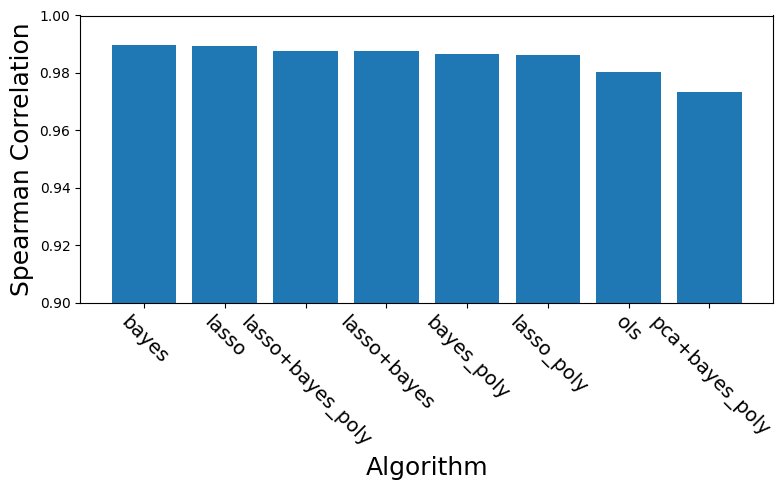

In [42]:
fig, ax = plt.subplots()

ax.bar(range(len(over_time_results)), over_time_results['force_spearman'])

ax.set_xticks(range(len(over_time_results)))
ax.set_xticklabels(list(over_time_results.index), fontsize=14, rotation=-45);

ax.set_ylim(0.9, 1)
ax.set_ylabel('Spearman Correlation', fontsize=18)
ax.set_xlabel('Algorithm', fontsize=18)

fig.set_size_inches(8, 5)
fig.tight_layout()

Show the tradeoff between the spearman $\rho$ and MAE

Best MAE: bayes
Best SCC: bayes


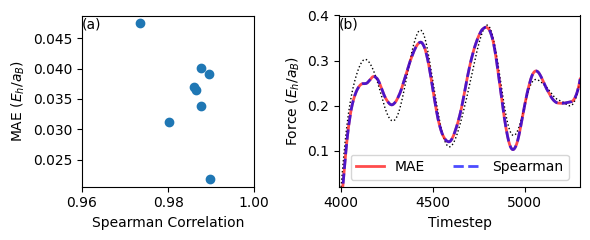

In [43]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,1.4]})

# Plot all the performances
axs[0].scatter(over_time_results['force_spearman'],
          over_time_results['force_mae'])

axs[0].set_xlabel('Spearman Correlation')
axs[0].set_ylabel('MAE ($E_h / a_B$)')
axs[0].set_xlim(0.96, 1.0)
axs[0].text(0.0, 0.99, '(a)', va='top', transform=axs[0].transAxes)

# Plot the best MAE vs Best SCC
best_mae = over_time_results['force_mae'].idxmin()
print(f'Best MAE: {best_mae}')
best_scc = over_time_results['force_spearman'].idxmax()
print(f'Best SCC: {best_scc}')

tddft, = axs[1].plot(data['timestep'], data['force'], 'k:', lw=1, label='none')
tddft.set_label(None)
axs[1].set_ylim([0.02,0.4]) # Make sure the scales stay appropriate
axs[1].set_xlim(3990, 5300)

traj = test_results[best_mae]['over_time']['traj'][experiment_number]
axs[1].plot(data['timestep'], traj, 'r-', alpha=0.7, lw=2, label='MAE')

traj = test_results[best_scc]['over_time']['traj'][experiment_number]
axs[1].plot(data['timestep'], traj, 'b--', alpha=0.7, lw=2, label='Spearman')

axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Force ($E_h/a_B$)')
axs[1].legend(ncol=2, loc='lower center')

axs[1].text(0.0, 0.99, '(b)', va='top', transform=axs[1].transAxes)

fig.set_size_inches(6, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'mae-vs-spearman.png'), dpi=320)
fig.savefig(os.path.join('figures', 'mae-vs-spearman.pdf'))

*Finding*: The model selected using spearman fits low-force data more accurately

Save the results

In [44]:
with open('model-comparision-results.pkl', 'wb') as fp:
    pkl.dump(test_results, fp)

Select the best model

In [45]:
best_model = over_time_results.index[0]
print('Best model:', best_model)

Best model: bayes


## Plot just the best one
Show the model performance

In [46]:
best_results = test_results['lasso+bayes_poly'] # This fits the data the best at large training set sizes

In [47]:
pkl.dump(best_results['model'], open('best_model.pkl', 'wb'))

Plot how well the algorithm forecasts stopping force

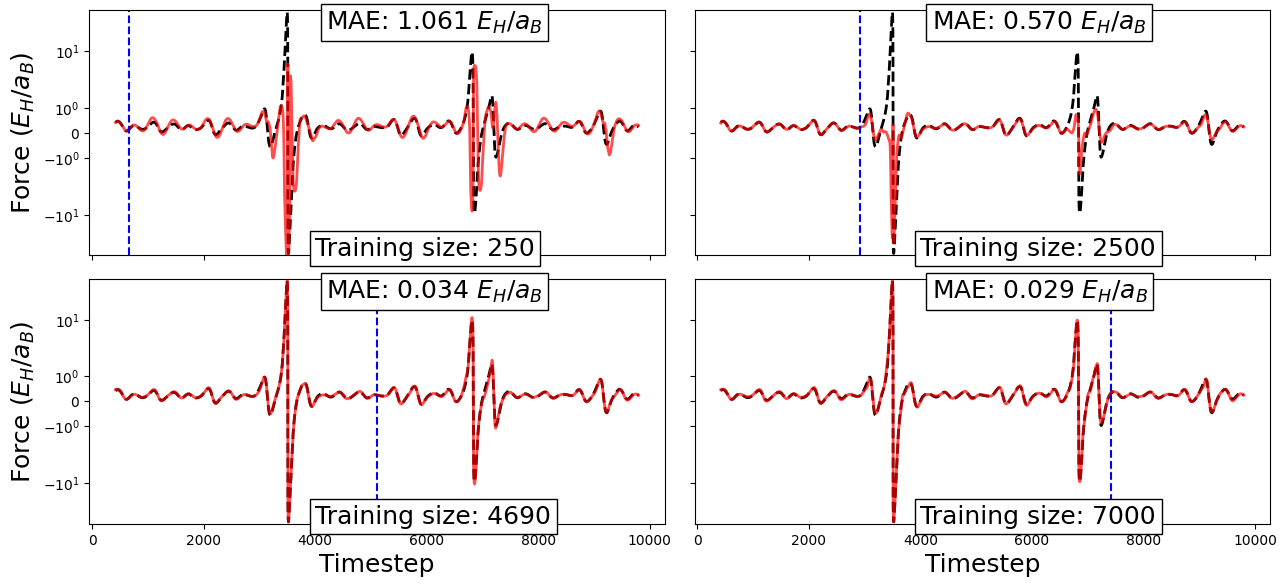

In [48]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], data['force'], 'k--', lw=2)
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], traj, 'r-', alpha=0.7, lw=2)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(4200, 30, 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=18,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.text(4000, -80, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=18,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')
    
    ax.set_yscale('symlog')

axs[1,0].set_xlabel('Timestep', fontsize=18)
axs[1,1].set_xlabel('Timestep', fontsize=18)
axs[0,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)
axs[1,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)

fig.set_size_inches(13,6)
fig.tight_layout()

fig.savefig(os.path.join('figures', 'random-trajectory-fit.png'), dpi=320)

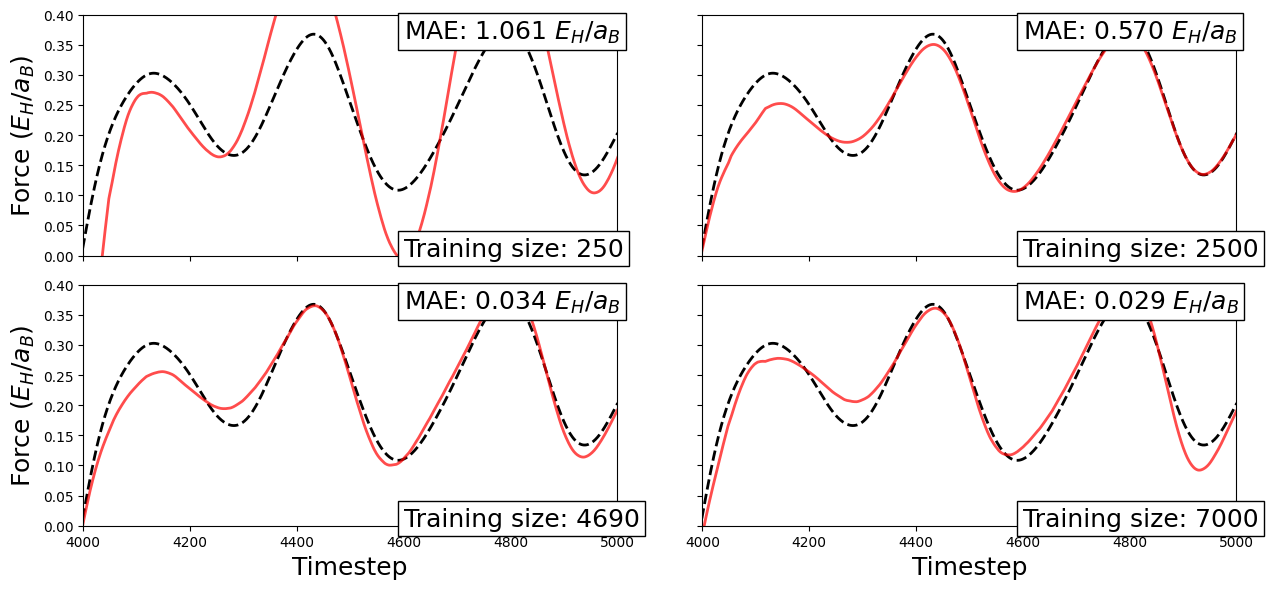

In [49]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], data['force'], 'k--', lw=2)
    ax.set_ylim([0,0.4]) # Make sure the scales stay appropriate
    ax.set_xlim(4000, 5000)
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], traj, 'r-', alpha=0.7, lw=2)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(0.6, 0.9, 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=18,
           bbox=dict(edgecolor='k', facecolor='w'), transform=ax.transAxes)
    
    ax.text(0.6, 0, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=18, bbox=dict(edgecolor='k', facecolor='w'), transform=ax.transAxes)
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep', fontsize=18)
axs[1,1].set_xlabel('Timestep', fontsize=18)
axs[0,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)
axs[1,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)

fig.set_size_inches(13,6)
fig.tight_layout()

The above figure shows the fitness of the model as a function of training set size. In each frame, the model is trained on the data to the left of the blue, vertical line. The predictions of the model are shown in red and the TD-DFT result in black. After we've trained the model on half of the dataset (bottom left), the model fits the entire trajectory very well. At this point, we could stop the TD-DFT simulation and, instead, use our ML surrogate to compute the stopping power. By using the surrogate instead, we would get the same result as TD-DFT with only half of the computational expense.

### Make a learning curve
Show the MAE as training set size

In [50]:
first_pass = data['timestep'][data['force'].idxmax()]
second_pass = data['timestep'][(data['force'].iloc[5000:]).idxmax()]
print('First pass is near timestep', first_pass)
print('Second pass is near timestep', second_pass)

First pass is near timestep 3498
Second pass is near timestep 6813


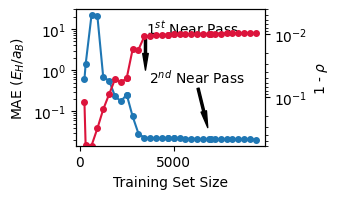

In [51]:
fig, ax = plt.subplots()

maes = [np.abs(data['force'] - t).mean() for t in test_results[best_scc]['over_time']['traj']]
sccs = [1 - stats.spearmanr(data['force'], t)[0] for t in test_results[best_scc]['over_time']['traj']]

ax.semilogy(test_results[best_scc]['over_time']['training_size'], maes, 'o-', markersize=4)
ax2 = ax.twinx()

ax2.semilogy(test_results[best_scc]['over_time']['training_size'], sccs, 'o-', color='crimson', markersize=4)
ax2.set_ylim(0.6, 4e-3)
ax2.set_ylabel('1 - $ \\rho $')

ax.annotate('1$^{st}$ Near Pass', xy=(first_pass - data['initial'].sum(), 1),
           xytext=(3500, 8), arrowprops={'facecolor': 'k', 'width': 1.5, 'headwidth': 4})
ax.annotate('2$^{nd}$ Near Pass', xy=(second_pass - data['initial'].sum(), 0.04),
           xytext=(3700, 0.5), arrowprops={'facecolor': 'k', 'width': 1.5, 'headwidth': 4})

ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE ($E_H / a_B$)')

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'random-learning-curve.png'), dpi=320)

## Make it an animation
Show the fitness improving as more training data is added

In [52]:
model = best_results['model']

In [54]:
frames = np.linspace(10, len(data) / 2, 200, dtype=int)

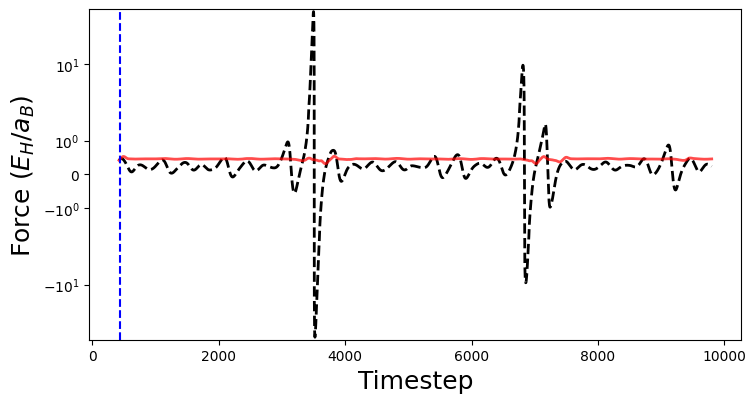

In [55]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force'], 'k--', lw=2)

model.fit(data[X_cols].iloc[:10], data[y_col].iloc[:10])
lne, = ax.plot(data['timestep'], model.predict(data[X_cols]), 'r-', alpha=0.7, lw=2)
ax.set_ylim(ax.get_ylim())
bar, = ax.plot([data['timestep'].iloc[:1].max(),]*2, ax.get_ylim(), 'b--')

def update(frame):
    size = frames[frame]
    model.fit(data[X_cols].iloc[:size], data[y_col].iloc[:size])
    lne.set_data(data['timestep'], model.predict(data[X_cols]))
    
    bar.set_data([data['timestep'].iloc[:size].max(),]*2, ax.get_ylim())
    return lne, bar
    
anim = FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

ax.set_yscale('symlog')
ax.set_xlabel('Timestep', fontsize=18)
ax.set_ylabel('Force ($E_H/a_B$)', fontsize=18)
fig.tight_layout()
fig.set_size_inches(8, 4)

This video shows the changes in the fitness of the model as we add new training data. In each frame, the model is trained using all of the data to the left of the blue bar. The black line is the TD-DFT result and the red line in the ML prediction. Notice how the model first starts to accurately predict the stopping power in low-force region and then accurately models the high force regions. After we gather about half of the training data, our model predictions no longer fluctuate with adding more data. 

In [56]:
#anim.save(os.path.join('figures', 'training-animation.mp4'), dpi=330, writer='ffmpeg')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4